<a href="https://colab.research.google.com/github/ThatGuyDV/CNNapproches/blob/master/imagenette_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import os 
import tensorflow as tf
import tarfile

In [2]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz

--2020-07-10 05:34:18--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.114.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.114.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98752094 (94M) [application/x-tar]
Saving to: ‘imagenette-160.tgz’

imagenette-160.tgz  100%[===================>]  94.18M  78.9MB/s    in 1.2s    

2020-07-10 05:34:20 (78.9 MB/s) - ‘imagenette-160.tgz’ saved [98752094/98752094]



In [3]:
with tarfile.open('/content/imagenette-160.tgz', 'r') as f:
  f.extractall()

In [4]:
path = pathlib.Path('/content/imagenette-160')

In [5]:
train_dir = path/'train'
val_dir = path/'val'

In [6]:
train_file_count = len(list(train_dir.glob('*/*.JPEG')))

In [7]:
train_file_count

12894

In [29]:
val_file_count = len(list(val_dir.glob('*/*.JPEG')))
val_file_count

500

In [8]:
batch_size = 64
im_size = (128,128)

In [9]:
labels = ['tench', 'English springer', 'cassette player', 
          'chain saw', 'church', 'French horn', 'garbage truck',
          'gas pump', 'golf ball', 'parachute']

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,rescale = 1./255
)

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir, shuffle=True, 
             target_size = im_size, 
             batch_size=batch_size, interpolation = 'bilinear')

Found 12894 images belonging to 10 classes.


In [12]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)

In [13]:
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=batch_size,
                              target_size = im_size, interpolation="bilinear")

Found 500 images belonging to 10 classes.


In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(labels[int(np.where(label_batch[n]==1)[0])].title())
      plt.axis('off')

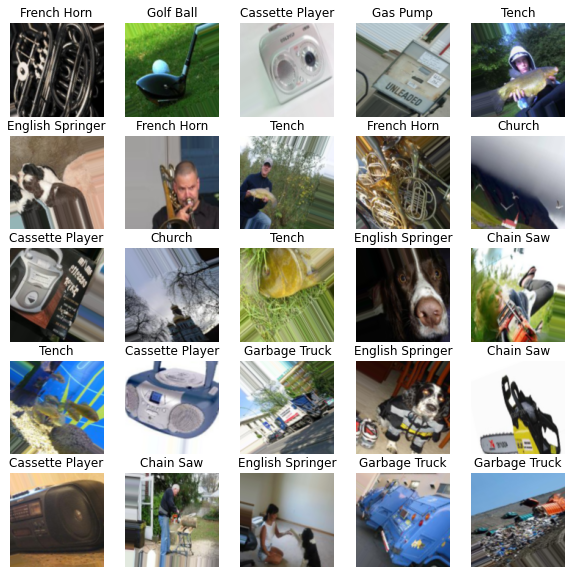

In [ ]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

In [16]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3), include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
# base_model.trainable = False

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, \
Flatten, MaxPooling2D, Conv2D

In [19]:
# model = Sequential([base_model, GlobalAveragePooling2D(), \
#                    Dense(10, activation = 'sigmoid')])

In [31]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation= 'sigmoid')
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [34]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

In [35]:
epochs = 30
opimzer = Adam()
es = EarlyStopping(monitor='val_loss', patience=2)
scd = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [36]:
model.compile(optimizer=opimzer, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [37]:
history = model.fit_generator(train_generator, epochs = epochs, callbacks=[es, scd],
                              validation_data = val_generator, 
                              steps_per_epoch = train_file_count//batch_size, 
                              validation_steps = val_file_count//batch_size)

Epoch 1/30
201/201 [==============================] - 73s 363ms/step - loss: 1.9042 - accuracy: 0.3253 - val_loss: 1.3460 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 2/30
201/201 [==============================] - 74s 367ms/step - loss: 1.5602 - accuracy: 0.4720 - val_loss: 1.2139 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 3/30
201/201 [==============================] - 75s 371ms/step - loss: 1.4202 - accuracy: 0.5161 - val_loss: 1.1338 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 4/30
201/201 [==============================] - 72s 358ms/step - loss: 1.3114 - accuracy: 0.5620 - val_loss: 0.9906 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 5/30
201/201 [==============================] - 72s 357ms/step - loss: 1.2302 - accuracy: 0.5935 - val_loss: 1.0466 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 6/30
201/201 [==============================] - 72s 357ms/step - loss: 1.1705 - accuracy: 0.6133 - val_loss: 1.0450 - val_accuracy: 0.6652 - lr: 0.0010


In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

def plots(acc, val_acc, loss, val_loss):
  figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  # plt.figsize = (16,16)
  plt.subplot(1,2,1)
  plt.plot(acc, label='training accuracy')
  plt.plot(val_acc, label='validation accuracy')
  plt.legend(loc='lower right')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(loss, label='training loss')
  plt.plot(val_loss, label='validation loss')
  plt.legend(loc='upper right')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training and validation loss')

  figure.tight_layout(pad = 3)

In [48]:
history = model.fit_generator(train_generator, epochs = epochs, callbacks=[scd],
                              validation_data = val_generator, 
                              steps_per_epoch = train_file_count//batch_size, 
                              validation_steps = val_file_count//batch_size)

Epoch 1/30
201/201 [==============================] - 73s 361ms/step - loss: 1.1316 - accuracy: 0.6248 - val_loss: 0.9408 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 2/30
201/201 [==============================] - 73s 361ms/step - loss: 1.0937 - accuracy: 0.6345 - val_loss: 0.9415 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 3/30
201/201 [==============================] - 73s 361ms/step - loss: 1.0637 - accuracy: 0.6475 - val_loss: 0.9757 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 4/30
201/201 [==============================] - 73s 362ms/step - loss: 1.0275 - accuracy: 0.6584 - val_loss: 0.8672 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 5/30
201/201 [==============================] - 72s 361ms/step - loss: 0.9950 - accuracy: 0.6673 - val_loss: 0.8497 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 6/30
201/201 [==============================] - 73s 362ms/step - loss: 0.9728 - accuracy: 0.6773 - val_loss: 0.8428 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 7/30
201/201 [==============================] 

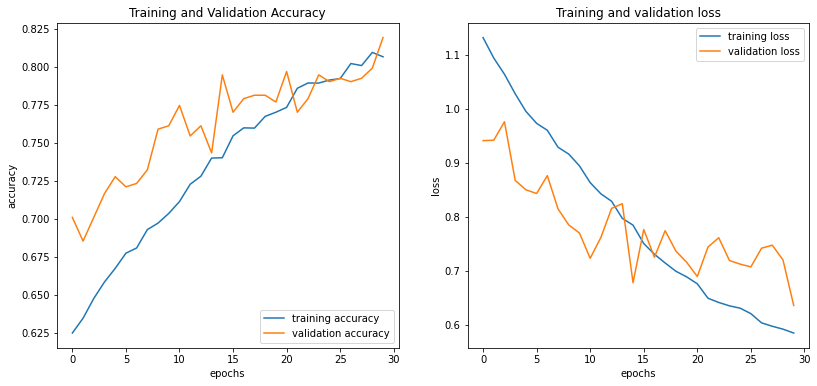

In [51]:
plots(acc, val_acc, loss, val_loss)